# Exploration of room simulation methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
import pyroomacoustics as pra
from pyroomacoustics.beamforming import MicrophoneArray
import math
from collections import defaultdict
%matplotlib notebook

## Create 2D room

<IPython.core.display.Javascript object>


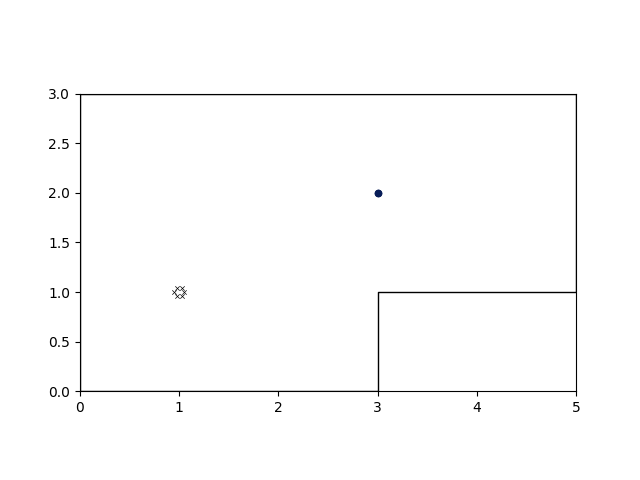

In [3]:
corners = np.array([[0,0], [0,3], [5,3], [5,1], [3,1], [3,0]]).T

fs, audio = wavfile.read("../sounds/CantinaBand3.wav")

room = pra.Room.from_corners(corners, fs=fs)
room.add_source([3., 2.], signal=audio)

# add circular array
R = pra.circular_2D_array(center=[1, 1], M=6, phi0=0, radius=0.05)
room.add_microphone_array(R)

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])

plt.show()

### Simulate the room created above

In [4]:
room.simulate()

data = room.mic_array.signals.T
cols = [f'mic_{i}' for i in range(1, 7)]
df = pd.DataFrame(data=data, columns=cols, dtype=np.int16)

df.to_csv(f'../training_data/simulation2D.csv')

## Create 3D room

<IPython.core.display.Javascript object>


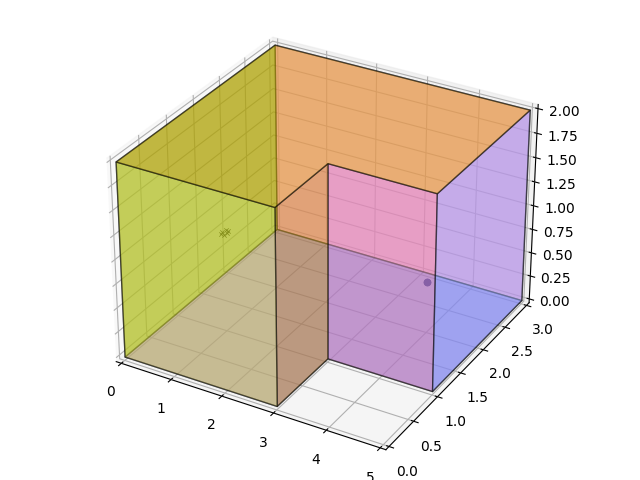

In [7]:
room = pra.Room.from_corners(corners)
room.extrude(2.)
room.add_source([4., 2., 0.5], signal=audio, delay=0.5)
R = pra.circular_2D_array(center=[1, 1], M=6, phi0=0, radius=0.05)

# Add the array after extending it to 3D
room.add_microphone_array(np.vstack((R, [1] * 6)))

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
ax.set_zlim([0, 2]);

### Simulate the 3D room

In [8]:
room.simulate()

data = room.mic_array.signals.T
cols = [f'mic_{i}' for i in range(1, 7)]
df = pd.DataFrame(data=data, columns=cols, dtype=np.int16)

df.to_csv(f'../training_data/simulation3D.csv')

df.iloc[4500:4520]

,mic_1,mic_2,mic_3,mic_4,mic_5,mic_6
4500,-1,-1,-1,-1,-1,-2
4501,0,-1,-1,-1,-2,-2
4502,0,0,0,0,-1,0
4503,0,0,1,-1,0,0
4504,2,1,0,0,0,0
4505,2,2,2,0,0,2
4506,1,1,2,1,3,1
4507,3,3,1,2,1,3
4508,2,1,3,2,3,2
4509,1,2,1,3,3,2


# Simulate room to gather training data
For basic data collection, we will generate a shoebox room with dimensions 4m by 4m by 2m. We will then place the microphone array in the middle and experiment with sound sources at all angles (0-359 degrees) around it, and at a couple different distances.

In [9]:
def create_simulation_room(room_dim=[4, 4, 2], mic_pos=[2, 2, 1], room_fs=16000):
    """
    Utility function to create a shoebox room,
    with a microphone array included.
    """
    
    # Initialize room
    room = pra.ShoeBox(room_dim, fs=room_fs)

    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.05

    # Generate the microphone array
    mic_array_2D = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=0.05)
    mic_array_3D = np.vstack((mic_array_2D, [mic_height] * 6))
    
    # Add the microphone array to room
    room.add_microphone_array(mic_array_3D)
    
    return room

def create_sound_sources(resolution=1):
    """
    Function that creates a list of all audio source,
    that will be placed inside the room for simulation.
    """
    
    #Specify angle in distance ranges
    angle_range = range(0, 360, resolution)
    dist_range = np.linspace(0.5, 2, 10)
   
    sources = defaultdict(list)

    for angle in angle_range:
        for R in dist_range:
            source = [R * math.cos(math.radians(angle)) + 2, R * math.sin(math.radians(angle)) + 2, 1]
            sources[angle].append((R, source))
            
    return sources

## Some sanity checks
Here let's create a room using a function defined above and add sound sources to it. We can see what the effective room looks like using a 3D plot that will show the microphone array and all sound sources that were created.

<IPython.core.display.Javascript object>


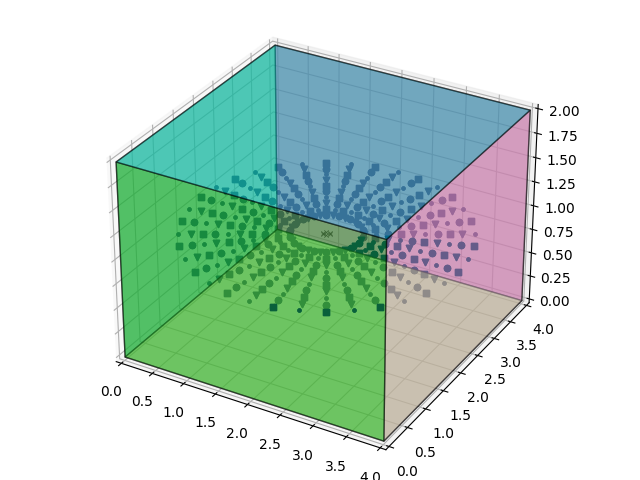

In [14]:
room = create_simulation_room()
sources = create_sound_sources(resolution=10)

# Add every single source to the room
for angle, sources in sources.items():
    for _, source in sources:
        room.add_source(source, signal=audio, delay=0.5)

# Plot the room
fig, ax = room.plot()
ax.set_xlim([0, 4])
ax.set_ylim([0, 4])
ax.set_zlim([0, 2]);

We can see above that everything worked properly, meaning that we can proceed to simulating all the sources and saving microphone readings to CSV files, which will facilitate processing them later.

## Running simulations
Let's now run simulations in the room defined above, using an angle resolution of 20 degrees as an example. This should be later changed to 1 though, because even if we're aiming for 20 degrees classification resolution, we should still collect data with 1 degree resolution and later just assign the same label to all angles in range 0-19, 20-39, etc.

In [17]:
def simulate_room(audio_file, resolution=1, room_dim=[4, 4, 2], mic_pos=[2, 2, 1]):
    """
    Function to simulate room with specified dimensions and microphone array position.
    Generates CSV files for all angle/distance combinations.
    
    Returns: a dictionary with all dataframes that were created.
    Keys are in a form of (angle, distance) tuples
    """
    
    # Read the audio file
    fs, audio = wavfile.read(audio_file)
    
    # Create all sound sources
    sources = create_sound_sources(resolution)
    
    # Generate columns' names for each CSV file
    df_cols = [f'mic_{i}' for i in range(1, 7)]
    
    dataframes = {}
    
    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        print(f'Simulating {angle} degrees:', end=' ')
        
        for dist, source in sources:
            sys.stdout.write("#")
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs)
            room.add_source(source, signal=audio, delay=0.5)
            room.simulate()

            # Exctract simulated signal for each microphone
            data = room.mic_array.signals.T
            
            # Save array data to a CSV file
            df = pd.DataFrame(data=data, columns=df_cols, dtype=np.int16)
            df['angle'] = angle    
            df.to_csv(f'../training_data/angle_{angle}_dist_{int(dist*100)}.csv')
            dataframes[(angle, dist)] = df
            
        print(' Done.')
            
    print('Simulation successful!')
            
    return dataframes

# Call the function above and store all results
dataframes = simulate_room('../sounds/CantinaBand3.wav', resolution=20)

Simulating 0 degrees: ########## Done.
Simulating 20 degrees: ########## Done.
Simulating 40 degrees: ########## Done.
Simulating 60 degrees: ########## Done.
Simulating 80 degrees: ########## Done.
Simulating 100 degrees: ########## Done.
Simulating 120 degrees: ########## Done.
Simulating 140 degrees: ########## Done.
Simulating 160 degrees: ########## Done.
Simulating 180 degrees: ########## Done.
Simulating 200 degrees: ########## Done.
Simulating 220 degrees: ########## Done.
Simulating 240 degrees: ########## Done.
Simulating 260 degrees: ########## Done.
Simulating 280 degrees: ########## Done.
Simulating 300 degrees: ########## Done.
Simulating 320 degrees: ########## Done.
Simulating 340 degrees: ########## Done.
Simulation successful!


## Plot some example data from the simulation
Just to make sure the simulation makes sense.

<IPython.core.display.Javascript object>


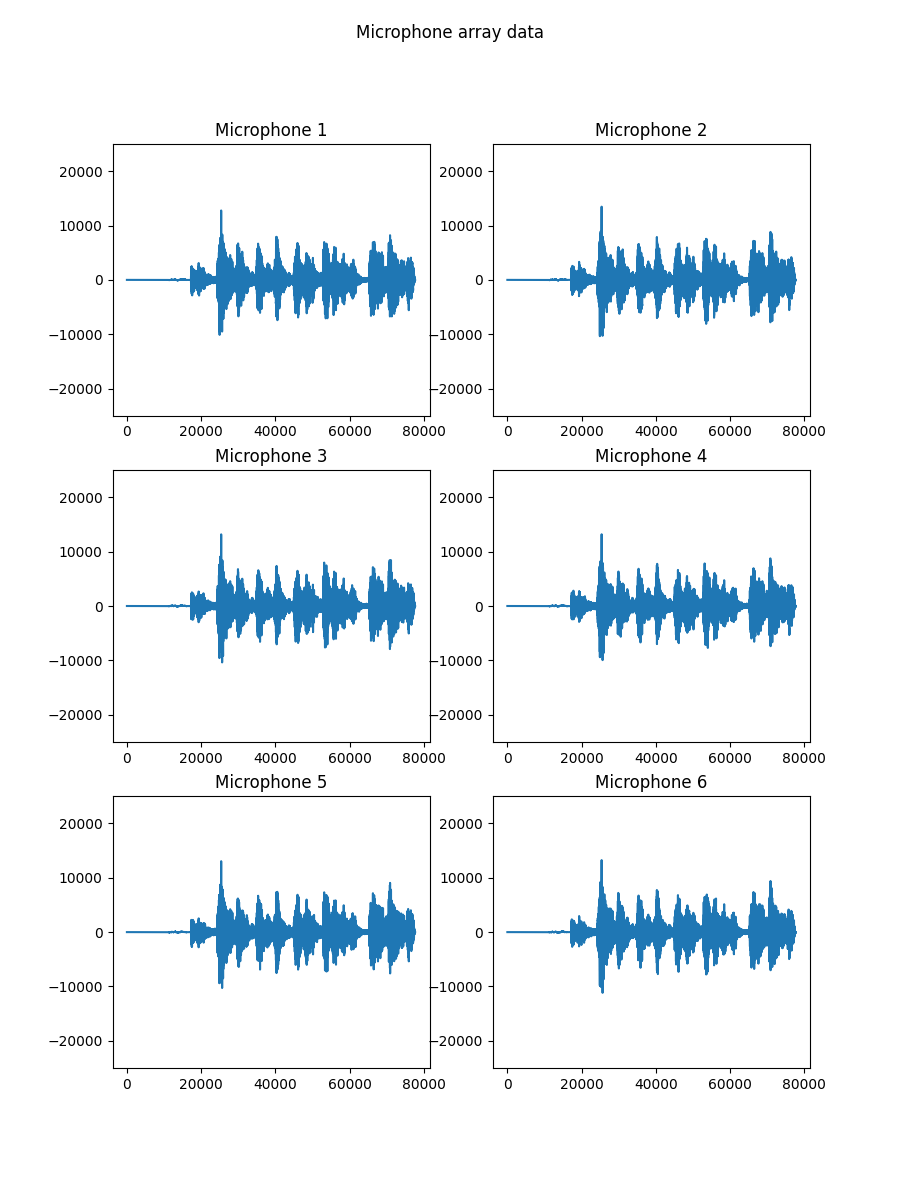

In [18]:
# Extract example mic array data (in this case, for angle 0)
example_mic_data = dataframes[(20, 2)]

fig, axs = plt.subplots(3, 2, figsize=(9,12))
fig.suptitle('Microphone array data')

for i in range(6):
    ax = axs[i//2][i%2]
    ax.set_title(f'Microphone {i+1}')
    ax.set_ylim([-25000, 25000])
    ax.plot(example_mic_data[f'mic_{i+1}'])